In [1]:
# Problem Statement:
# Pick a double integrator. Implement a PD controller for it.
# Use imitation learning (Dagger) to learn the PD controller.
# Use RL to improve on the imitation learning when there are disturbances.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
font = {'family' : 'serif',
        'serif' : 'Computer Modern Roman',
        'size'   : 16}
matplotlib.rc('font', **font)
matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['figure.figsize'] = [2*3.54, 3.54]

from systems import DoubleIntegrator, DoubleIntegratorWithPerturbations

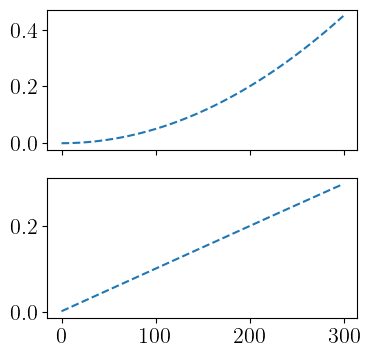

In [3]:
dt = 0.01
N = 300

# Systems
system = DoubleIntegrator(dt)
system_perturbed = DoubleIntegratorWithPerturbations(dt)

system.state = np.zeros(2)
system_perturbed.state = np.zeros(2)
state_list = []
state_perturb_list = []

for i in range(N):
    action = np.array([0.1])
    result = system.step(action)
    result_perturb = system_perturbed.step(action)
    state_list.append(system.state)
    state_perturb_list.append(system_perturbed.state)
    
fig, ax = plt.subplots(2, 1, figsize=(4, 4), sharex=True)
state_list = np.array(state_list)
state_perturb_list = np.array(state_perturb_list)
# ax[0].plot(state_list[:, 0], '-', label='x')
ax[0].plot(state_perturb_list[:, 0], '--', label='x with perturbations')
# ax[1].plot(state_list[:, 1], '-', label='\dot{x}')    
ax[1].plot(state_perturb_list[:, 1], '--', label='\dot{x} with perturbations')


In [4]:
# Expert Policies
class ExpertPolicyIntegral:
    def __init__(self, dt):
        self.integral_term = 0
        self.dt = dt
        self.K = np.array([40.0 , 30.0]).reshape(1, 2)
        self.K_I = 10.0
        
    def __call__(self, state, state_des):
        self.integral_term += - self.K_I * (state[0] - state_des[0]) * self.dt
        # TODO antiwindup 
        u = (-self.K @ (state - state_des))  + self.integral_term
        return u
    
class ExpertPolicyPD:
    def __init__(self, dt):
        self.dt = dt
        self.K = np.array([40.0 , 30.0]).reshape(1, 2)
        
    def __call__(self, state, state_des):
        u = (-self.K @ (state - state_des))
        return u

class ExpertPolicyNonlinearPD:
    def __init__(self, dt):
        self.dt = dt
        self.K = np.array([40.0 , 30.0]).reshape(1, 2)
        
    def __call__(self, state, state_des):
        u = (-self.K @ (state - state_des)) + (10*np.sin(state[0]/10))**2
        return u
        
expert_policy = ExpertPolicyPD(dt)
expert_policy_nonlinear = ExpertPolicyNonlinearPD(dt)

# Test the expert controller

Frequency 0.03708378174758048


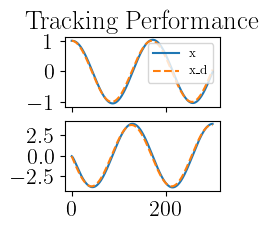

In [5]:
def desired_trajectory(N, dt):
    '''
    Args: 
        N : int - length of the trajectory
        dt : float - time step
    Returns:
        x_vec_d [x_d, x_dot_d] : np.array (N x 2) - desired trajectory
    '''
    frequency = np.random.uniform(0.01, 0.05)
    print('Frequency', frequency)
    x_d_fcn = lambda t: np.cos(t*frequency)
    x_d = [x_d_fcn(i) for i in range(N)]
    x_dot_d = np.zeros(N)

    for i in range(N - 1):
        x_dot_d[i] = (x_d[i+1] - x_d[i])/dt
    x_dot_d[-1] = x_dot_d[-2]

    x_vec_d = np.array([x_d, x_dot_d]).T
    return x_vec_d


x_vec_d = desired_trajectory(N, dt)
system_perturbed.state = np.array([x_vec_d[0, 0], x_vec_d[0, 1]])
state_list = []


des_traj_list = []
x0 = np.array([x_vec_d[0, 0], x_vec_d[0, 1]])
system_perturbed.state = x0.copy()

for i in range(N-1):
    state_des = np.array([ x_vec_d[i, 0], x_vec_d[i, 1] ])
    action = expert_policy(system_perturbed.state, state_des)
    result = system_perturbed.step(action)
    next_state = result[0]
    state_list.append(system_perturbed.state)
    des_traj_list.append(state_des)
    
state_list = np.array(state_list)
des_traj_list = np.array(des_traj_list)

fig, ax = plt.subplots(2, 1, figsize=(2, 2), sharex=True)
ax[0].set_title('Tracking Performance')
ax[0].plot(state_list[:, 0], '-', label='x')
ax[0].plot(des_traj_list[:, 0], '--', label='x_d')
ax[0].legend(fontsize='xx-small')

ax[1].plot(state_list[:, 1], '-', label='\dot{x}')
ax[1].plot(des_traj_list[:, 1], '--', label='\dot{x}_d')


Frequency 0.04503923905521594
Frequency 0.018058894909301144
Frequency 0.030268971499558844


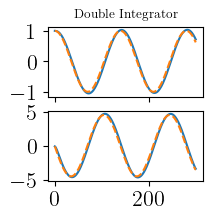

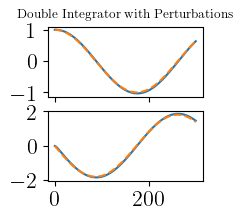

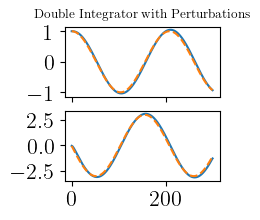

In [6]:


# Multiple traj regulation:
def multiple_traj_reg(sys, sys_name, policy):
    nb_traj = 1
    fig, ax = plt.subplots(2, 1, figsize=(2, 2), sharex=True)
    for i in range(nb_traj):
        sys.reset()
        state_list = []
        x_vec_d = desired_trajectory(N, dt)
        sys.state = np.array([x_vec_d[0, 0], x_vec_d[0, 1]])

        for i in range(N):
            state_des = np.array([ x_vec_d[i, 0], x_vec_d[i, 1] ])
            action = policy(sys.state, state_des)
            if type(action) is not np.ndarray:
                action = action.detach().numpy()
            result = sys.step(action)
            state_list.append(sys.state)
            
        state_list = np.array(state_list)
        ax[0].plot(state_list[:, 0], '-', label='x')
        ax[0].plot(x_vec_d[:, 0], '--', label='x_d')
        ax[1].plot(state_list[:, 1], '-', label='\dot{x}')    
        ax[1].plot(x_vec_d[:, 1], '--', label='\dot{x}_d')
        ax[0].set_title(sys_name, fontsize='xx-small')

multiple_traj_reg(system, sys_name = 'Double Integrator', policy=expert_policy)
multiple_traj_reg(system_perturbed, sys_name = 'Double Integrator with Perturbations', policy=expert_policy)
multiple_traj_reg(system_perturbed, sys_name = 'Double Integrator with Perturbations', policy=expert_policy_nonlinear)
    
    


# Train Dagger

In [7]:
from nnpolicy import NNPolicy
from DAgger import DAgger


In [8]:
input_size = 4
net_arch = [(input_size, 24), (24, 48), (48, 24), (24, 1)] # NN policy
policy = NNPolicy(net_arch)

In [9]:
epochs = 40

dagger_trainer = DAgger(system, expert_policy, policy, desired_trajectory, np.linspace(1, 0, epochs), 300, None, 1, input_size)

In [10]:
dagger_trainer.train_dagger(epochs)

Frequency 0.043235704165320986
Loss: 0.11694065481424332
[39.87907409667969, 12.969761848449707, 6.519432544708252, 3.3311965465545654, 0.9612143039703369, 0.6981557011604309, 0.46318039298057556, 0.24993617832660675, 0.14408941566944122, 0.12137355655431747, 0.1296282708644867, 0.15802963078022003, 0.13400979340076447, 0.12256112694740295, 0.11694065481424332, 0.12353821098804474, 0.12471921741962433, 0.12925992906093597, 0.1331503540277481, 0.14374664425849915, 0.15160918235778809, 0.15439163148403168, 0.15341472625732422, 0.14498065412044525, 0.1345466673374176, 0.12459544837474823, 0.11759036034345627, 0.11872140318155289, 0.11987944692373276, 0.12061508744955063]
Frequency 0.04050529244506961
Loss: 0.14368051290512085
[0.332058846950531, 0.508891761302948, 0.5350058674812317, 0.31999799609184265, 0.31745216250419617, 0.345704585313797, 0.3240002989768982, 0.307120144367218, 0.2872062027454376, 0.2753065228462219, 0.2661139667034149, 0.27455249428749084, 0.26324549317359924, 0.2599

Frequency 0.023789857595651498
Frequency 0.04763214097339945


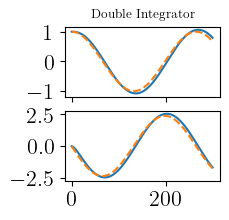

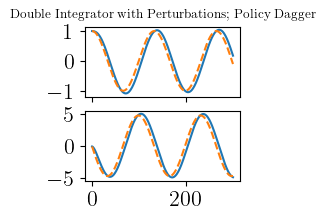

In [11]:
# Evaluate

def policy_NN(x, x_des):
    input_NN = np.concatenate([x, x_des])
    return policy.predict(input_NN)

multiple_traj_reg(system, sys_name = 'Double Integrator', policy=policy_NN)
multiple_traj_reg(system_perturbed, sys_name = 'Double Integrator with Perturbations; Policy Dagger', policy=policy_NN)


Frequency 0.023506662059501308


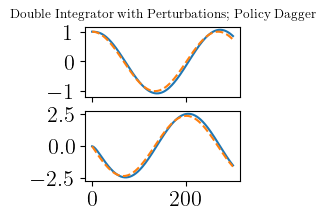

In [12]:
multiple_traj_reg(system_perturbed, sys_name = 'Double Integrator with Perturbations; Policy Dagger', policy=policy_NN)
